In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import econml
import importlib

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# Section 1. Synthetic Data Experiments

## Section 1.1. DGP with under represented samples on edge
$P(S=1 \mid X) = expit( 0.25 - 2\left((X_0 > 0.5) (X_0 < 1) (X_1 > 0.5) (X_1 < 1)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

### Section 1.1.1. Estimate the target treatment effect using IPW, Outcome Regression and Doubly Robust Estimator

(2.5724337024478223, 0.8056096440614813)
(2.7158190343685957, 0.03578070003649376)
(2.694105549043027, 0.06483286846611812)
2.715024374105188


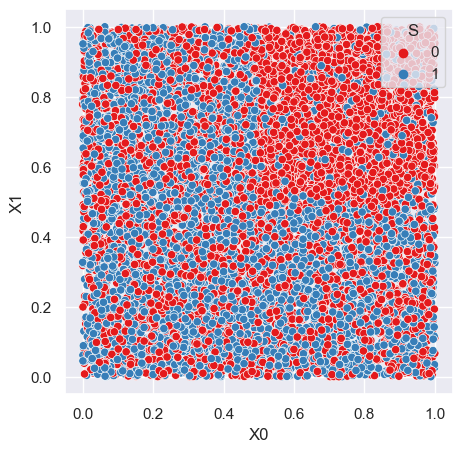

In [193]:
df, Y = strawman_edge.get_data(n=10000, seed=0)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="X0", y="X1", hue="S", data=df, palette="Set1")
fig.savefig("X0_vs_X1_hue_S.pdf", format="pdf", dpi=600)

atte_sim, atte_se_sim = est.estimate_sim(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
atte_out_reg, atte_se_outreg = est.estimate_out_reg(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
atte_dml, atte_se_dml = est.estimate_dml(
    data=df, outcome="Yobs", treatment="T", sample="S"
)
print((atte_sim, atte_se_sim))
print((atte_out_reg, atte_se_outreg))
print((atte_dml, atte_se_dml))
print((Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean())

#### Section 1.1.1.a Plotting the Point Estimates and Interval Widths

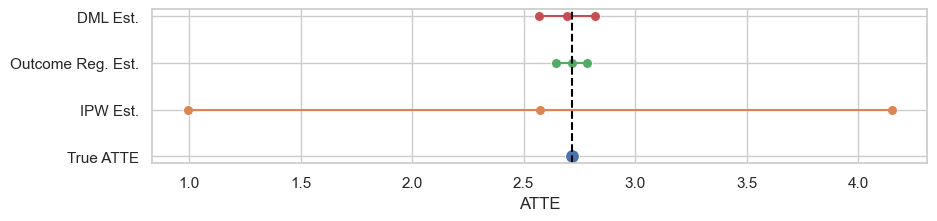

In [194]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 2))
sns.lineplot(
    x=[(Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean()],
    y=[0],
    ax=ax,
)
sns.scatterplot(
    x=[(Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean()],
    y=[0],
    ax=ax,
    s=100,
)
sns.lineplot(
    x=[atte_sim - (1.96 * atte_se_sim), atte_sim, atte_sim + (1.96 * atte_se_sim)],
    y=[1, 1, 1],
    ax=ax,
)
sns.scatterplot(
    x=[atte_sim - (1.96 * atte_se_sim), atte_sim, atte_sim + (1.96 * atte_se_sim)],
    y=[1, 1, 1],
    ax=ax,
    s=50,
)

sns.lineplot(
    x=[
        atte_out_reg - (1.96 * atte_se_outreg),
        atte_out_reg,
        atte_out_reg + (1.96 * atte_se_outreg),
    ],
    y=[2, 2, 2],
    ax=ax,
)
sns.scatterplot(
    x=[
        atte_out_reg - (1.96 * atte_se_outreg),
        atte_out_reg,
        atte_out_reg + (1.96 * atte_se_outreg),
    ],
    y=[2, 2, 2],
    ax=ax,
    s=50,
)

sns.lineplot(
    x=[
        atte_dml - (1.96 * atte_se_dml),
        atte_dml,
        atte_dml + (1.96 * atte_se_dml),
    ],
    y=[3, 3, 3],
    ax=ax,
)
sns.scatterplot(
    x=[
        atte_dml - (1.96 * atte_se_dml),
        atte_dml,
        atte_dml + (1.96 * atte_se_dml),
    ],
    y=[3, 3, 3],
    ax=ax,
    s=50,
)

plt.axvline(
    (Y["Y1"].loc[df["S"] == 0] - Y["Y0"].loc[df["S"] == 0]).mean(), c="black", ls="--"
)

plt.yticks([0, 1, 2, 3], ["True ATTE", "IPW Est.", "Outcome Reg. Est.", "DML Est."])
plt.xlabel("ATTE")
fig.savefig("ATTE_estimates.pdf", format="pdf", dpi=600)

### Section 1.1.2. Learning Optimal $w$ to improve precision of estimate
Here we primarly focus on Doubly Robust Estimator using different strategies to estimate $w(x)$

#### Section 1.1.2.a. Optimization via Linear $w(x)$

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06299201464233459
            Iterations: 17
            Function evaluations: 188
            Gradient evaluations: 17
(1.4785254952845208, 0.0629908923329548, 2.7000100352164367, 0.0629908923329548)


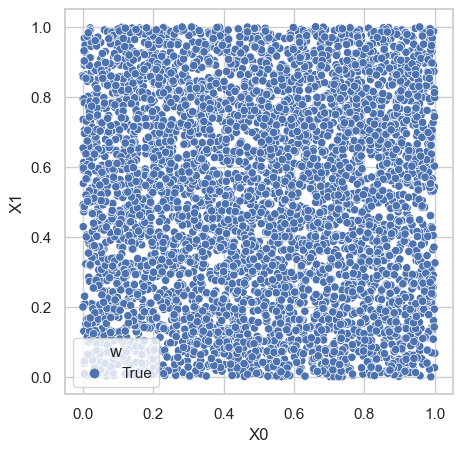

In [219]:
importlib.reload(learn)
D_label, coef_, f, testing_data = learn.linear_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", seed=530
)

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=D_label, x="X0", y="X1", hue="w", color="tab:orange")
fig.savefig("linear_opt_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.b. Optimization via Voronoi Sets using K-Means

(0.11919211420918746, 0.14508034690488394, 2.796204025472874, 2.831755070957463)


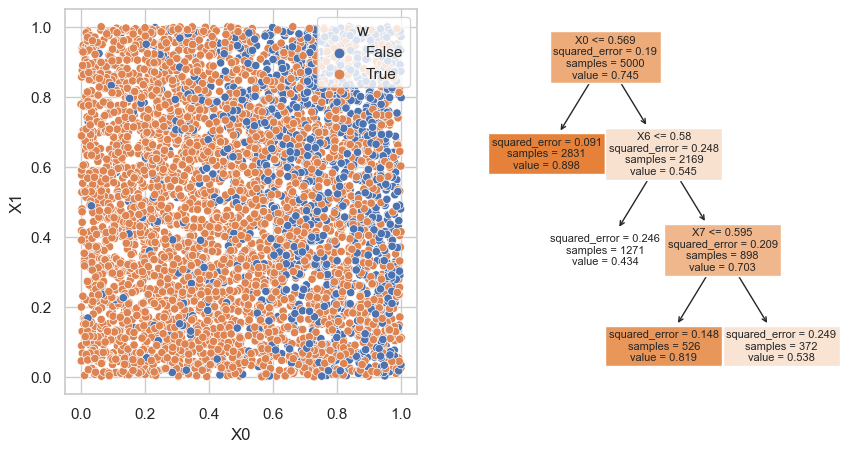

In [427]:
result, atte, se, atte_unpruned, se_unpruned, f, testing_data = learn.kmeans_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", k=20
)
print((se, se_unpruned, atte, atte_unpruned))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=testing_data, x="X0", y="X1", hue="w", ax=ax[0])

plot_tree = tree.plot_tree(
    f,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S", "w"]).columns,
    ax=ax[1],
    filled=True,
)
fig.savefig("voronoi_kmeans_opt_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.c. Optimization via (Randomized) Tree $w(x)$

## Split Function Algorithm

The following algorithm outlines the process of the `split` function used in the context of a decision-making process.

```python
function split(split_feature, X, D, parent_loss, depth):
    # Determine the feature fj to split on based on the current depth
    fj = choose(split_feature, depth)

    # Check if this is a base case where we're reaching a leaf node
    if fj equals "leaf":
        # Calculate losses for class 0 and class 1
        losses = { loss(v, X, D) : for v in {0,1} }
        
        # Decide whether to exploit (choose best loss) or explore (random choice)
        w_exploit = argmin(losses)
        w_explore = random.binomial(1, 0.5)
        
        # Introduce randomness in exploration
        explore = random.binomial(1, 0.05)
        
        # Combine exploration and exploitation to decide the final weight
        w = (explore * w_explore) + ((1 - explore) * w_exploit)
        
        # Update the weight in both the global and local datasets
        D.loc[X.index, "w"] = w
        X.loc[X.index, "w"] = w
        
        # Return information about this leaf node
        return {"node": fj, "w": w, "objective": min(losses), "depth": depth}
        
    # Induction case
    else:
        # Calculate the midpoint for the selected feature fj
        cj = midpoint(X[fj])
        
        # Split the dataset into left and right based on the midpoint
        X_left = X.loc[X[fj] <= cj]
        X_right = X.loc[X[fj] > cj]
        
        # Calculate losses for left and right branches
        loss_left = { loss(v, X_left, D) : for v in {0,1} } 
        loss_right = { loss(v, X_right, D) : for v in {0,1} } 
        
        # Find the minimum losses for both left and right branches
        min_loss_left = min(loss_left)
        min_loss_right = min(loss_right)

        # Calculate new loss after the split
        new_loss = ( |X_left| * min_loss_left + |X_right| * min_loss_right) / |X|
        
        # Check if the new split reduces loss compared to parent node
        if new_loss <= parent_loss:
            # Find best actions to take for left and right branches
            w_left = argmin(loss_left)
            w_right = argmin(loss_right)

            # Update weights in both global and local datasets for left branch
            D.loc[X_left.index, "w"] = w_left
            X_left.loc[X_left.index, "w"] = w_left

            # Update weights in both global and local datasets for right branch
            D.loc[X_right.index, "w"] = w_right
            X_right.loc[X_right.index, "w"] = w_right
            
            # Recursively split the left and right branches
            return {
                "node": fj,
                "split": cj,
                "left_tree": split(split_feature, X_left, D, new_loss, depth + 1),
                "right_tree": split(split_feature, X_right, D, new_loss, depth + 1),
                "objective": sqrt(sum(D["vsq"] * D["w"]) / ((sum((1 - D["S"]) * D["w"]) ** 2)))),
                "depth": depth,
            }
        else:
            # If the new split doesn't improve loss, try a different split feature
            split_feature_updated = reduce_weight(fj, copy(split_feature, deep=True))
            return split(split_feature_updated, X, D, parent_loss, depth)


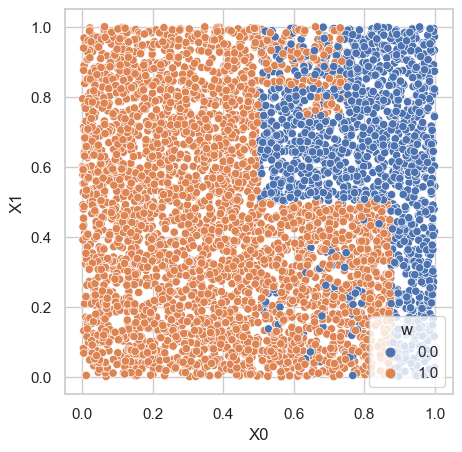

In [429]:
importlib.reload(learn)
D, w_tree, testing_data = learn.tree_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", leaf_proba=0.25, seed=1
)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharex=True, sharey=True)
sns.scatterplot(x="X0", y="X1", data=D, hue="w")
fig.savefig("forest_opt_500trees_result.pdf", format="pdf", dpi=600)

#### Section 1.1.2.d. Optimization via (Randomized) Forest $w(x)$ 
Trees with objective worse than baseline are pruned

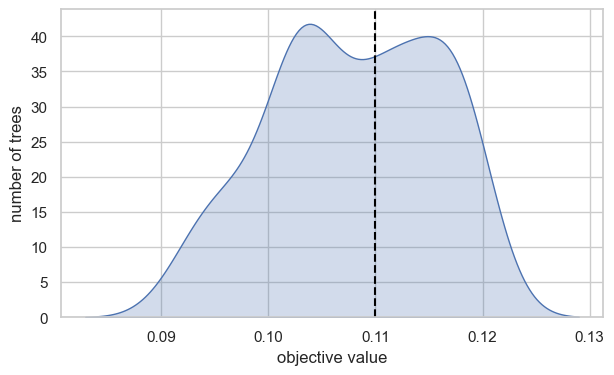

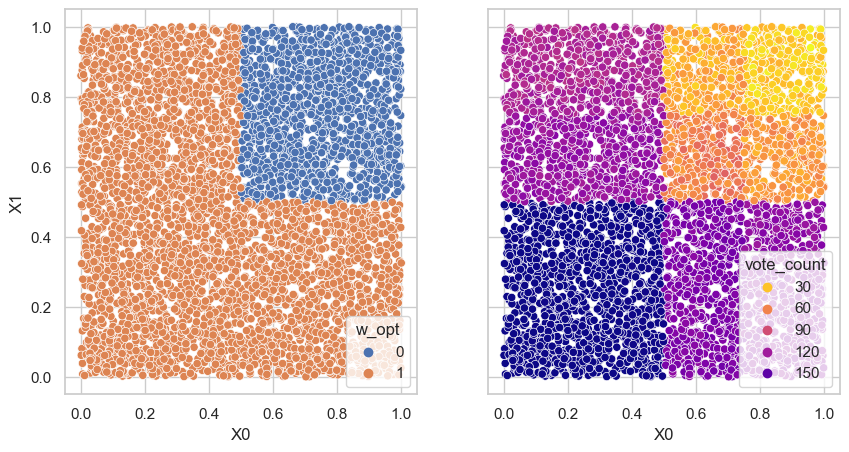

In [430]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, testing_data = learn.forest_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
    leaf_proba=1,
    num_trees=500,
    vote_threshold=1 / 2,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((np.sum((1 - D_forest["S"])) ** 2)))

fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
# sns.histplot(
#     D_forest[[col for col in D_forest.columns if "w_tree" in col]].mean(), ax=ax[0]
# )

sns.kdeplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < 0.12
    ],
    ax=ax,
    fill=True,
)
ax.axvline(0.11, c="black", ls="--")
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")

# D_w_rash = D_forest[["w_tree_%d" % (i) for i in rashomon_set]]
# D_forest["w opt"] = (D_w_rash.mean(axis=1) > (2 / 3)).astype(int)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
sns.scatterplot(x="X0", y="X1", hue="w_opt", data=D_rash, ax=ax[0])
sns.scatterplot(
    x="X0", y="X1", hue="vote_count", data=D_rash, ax=ax[1], palette="plasma_r"
)
fig.savefig("forest_opt_500trees_result.pdf", format="pdf", dpi=600)

## Section 1.2. All Linear DGP
$Y(0) = \beta_0^T X + \epsilon$ \
$Y(1) = Y(0) + \beta_1^T X + \epsilon$ \
$P(S=1 \mid X ) = expit( \alpha_0^T X )$

(array([-4.18201994,  1.42942861, -0.95389448, ..., -0.6601245 ,
        0.00616464, -2.52296175]), array([0.01503804, 0.80681227, 0.27810228, ..., 0.34071164, 0.50154116,
       0.07426407]))


coef. X0  coef. X1  coef. X2  coef. X3  coef. X4  coef. X5  \
selection           0.0      -1.0       0.0       1.0      1.00       0.0   
heterogeneity       4.0       2.0       1.0       0.5      0.25       0.0   

               coef. X6  coef. X7  coef. X8  coef. X9  coef. X10  coef. X11  \
selection           0.0      -1.0       1.0       1.0        1.0       -1.0   
heterogeneity       0.0       0.0       0.0       0.0        0.0        0.0   

               coef. X12  coef. X13  coef. X14  coef. X15  coef. X16  \
selection            0.0        0.0        0.0        1.0        0.0   
heterogeneity        0.0        0.0        0.0        0.0        0.0   

               coef. X17  coef. X18  coef. X19  
selection            0.0        0.0       -1.0  
heterogeneity        0.0        0.0        0.0

<Axes: xlabel='X1', ylabel='X3'>

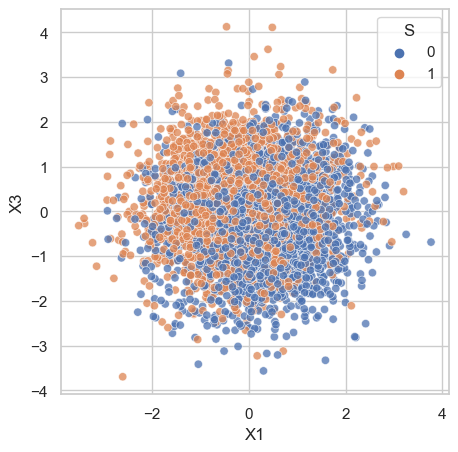

In [39]:
importlib.reload(all_linear)
df, Y, coef = all_linear.get_data(n=5000, seed=1)

display(pd.DataFrame(coef, index=["coef. X%d" % (i) for i in range(20)]).T)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")
#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="X1", y="X3", hue="S", data=df, alpha=0.75, ax=ax)


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 4.803227E-02    MAXCV = 0.000000E+00
   X =-4.032985E-01  -6.991900E+00   2.528755E+00   7.660793E+00   5.452323E+00
       2.473308E+00   4.241774E-01  -4.246757E+00   6.544103E+00   6.297983E+00
       4.944117E+00  -6.499167E+00   2.635765E-01  -1.546276E+00   9.230058E-01
       5.188625E+00  -3.368909E-01  -7.815474E-01   1.626477E-01  -7.163162E+00
(-0.10441247969952004, 0.04624560781934805, 0.29650986595182005, 0.0630180556595968)
[-0.40329849 -6.99189955  2.52875506  7.66079345  5.45232294  2.47330834
  0.42417738 -4.2467571   6.54410336  6.29798312  4.94411652 -6.49916725
  0.26357651 -1.54627646  0.92300583  5.18862464 -0.33689086 -0.78154739
  0.16264765 -7.16316158]


[Text(0.5, 0.875, 'X1 <= -0.322\ngini = 0.5\nsamples = 2500\nvalue = [1280, 1220]'),
 Text(0.25, 0.625, 'X3 <= -0.641\ngini = 0.442\nsamples = 898\nvalue = [296, 602]'),
 Text(0.125, 0.375, 'X8 <= -0.149\ngini = 0.491\nsamples = 222\nvalue = [126, 96]'),
 Text(0.0625, 0.125, 'gini = 0.352\nsamples = 101\nvalue = [78, 23]'),
 Text(0.1875, 0.125, 'gini = 0.479\nsamples = 121\nvalue = [48, 73]'),
 Text(0.375, 0.375, 'X19 <= 0.358\ngini = 0.376\nsamples = 676\nvalue = [170, 506]'),
 Text(0.3125, 0.125, 'gini = 0.257\nsamples = 430\nvalue = [65, 365]'),
 Text(0.4375, 0.125, 'gini = 0.489\nsamples = 246\nvalue = [105, 141]'),
 Text(0.75, 0.625, 'X4 <= 0.3\ngini = 0.474\nsamples = 1602\nvalue = [984, 618]'),
 Text(0.625, 0.375, 'X19 <= 0.362\ngini = 0.408\nsamples = 1029\nvalue = [735, 294]'),
 Text(0.5625, 0.125, 'gini = 0.477\nsamples = 630\nvalue = [383, 247]'),
 Text(0.6875, 0.125, 'gini = 0.208\nsamples = 399\nvalue = [352, 47]'),
 Text(0.875, 0.375, 'X11 <= 0.306\ngini = 0.491\nsamples 

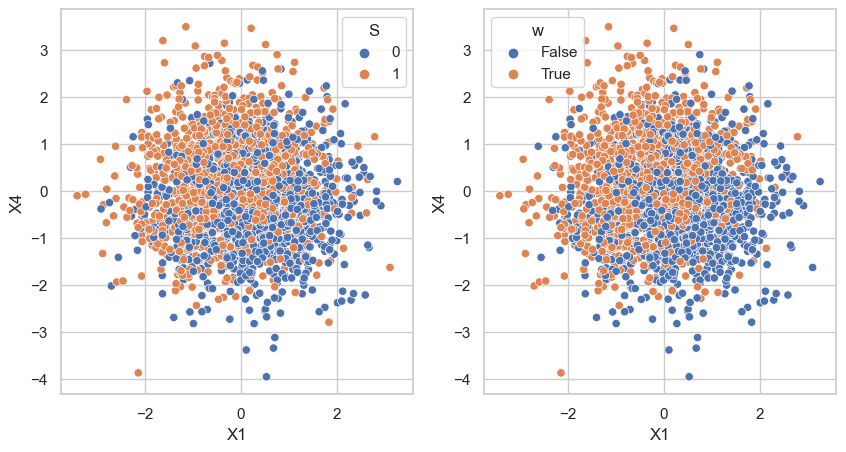

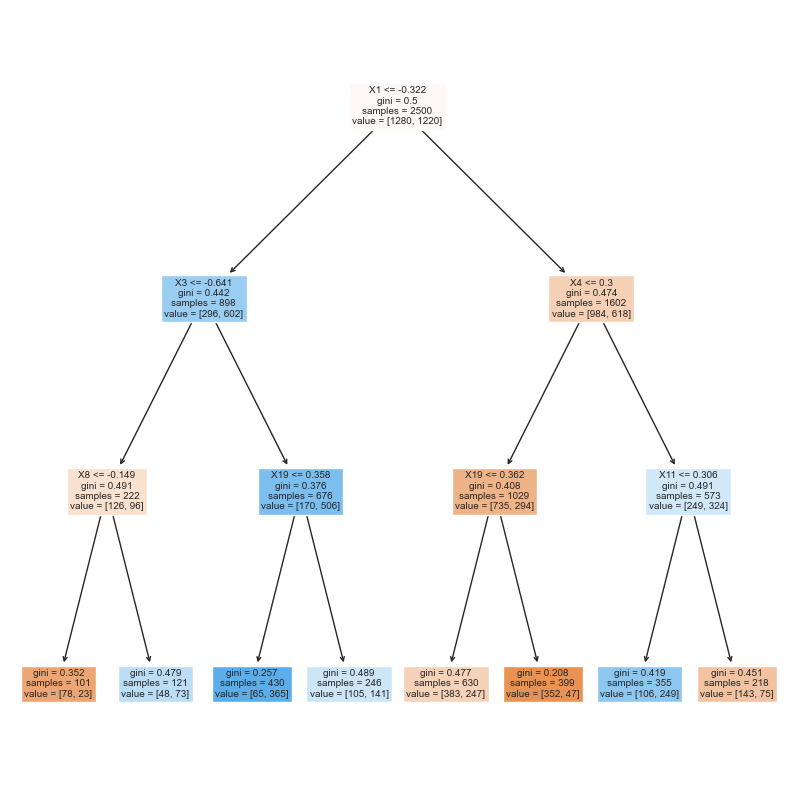

In [42]:
importlib.reload(learn)
D_labels, result, f, testing_data = learn.linear_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
)

print(result.x)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(data=D_labels, x="X1", y="X4", hue="w", ax=ax[1])
sns.scatterplot(data=D_labels, x="X1", y="X4", hue="S", ax=ax[0])
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
tree.plot_tree(
    f,
    ax=ax,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S"]).columns,
    filled=True,
)
# fig.savefig("linear_opt_result.pdf", format="pdf", dpi=600)

leaf    0.500000
X0      0.006795
X1      0.056473
X2      0.004529
X3      0.039416
X4      0.043879
X5      0.016564
X6      0.000923
X7      0.038634
X8      0.052349
X9      0.039733
X10     0.032292
X11     0.039184
X12     0.013662
X13     0.000348
X14     0.003987
X15     0.028255
X16     0.007924
X17     0.008973
X18     0.020662
X19     0.045418
dtype: float64


[Text(0.5, 0.875, 'X1 <= 1.482\ngini = 0.295\nsamples = 2500\nvalue = [449, 2051]'),
 Text(0.25, 0.625, 'X1 <= 0.22\ngini = 0.218\nsamples = 2332\nvalue = [290, 2042]'),
 Text(0.125, 0.375, 'X1 <= -1.753\ngini = 0.064\nsamples = 1444\nvalue = [48, 1396]'),
 Text(0.0625, 0.125, 'gini = 0.474\nsamples = 101\nvalue = [39, 62]'),
 Text(0.1875, 0.125, 'gini = 0.013\nsamples = 1343\nvalue = [9, 1334]'),
 Text(0.375, 0.375, 'X0 <= 0.037\ngini = 0.397\nsamples = 888\nvalue = [242, 646]'),
 Text(0.3125, 0.125, 'gini = 0.122\nsamples = 477\nvalue = [31, 446]'),
 Text(0.4375, 0.125, 'gini = 0.5\nsamples = 411\nvalue = [211, 200]'),
 Text(0.75, 0.625, 'X1 <= 1.557\ngini = 0.101\nsamples = 168\nvalue = [159, 9]'),
 Text(0.625, 0.375, 'X0 <= 0.661\ngini = 0.48\nsamples = 20\nvalue = [12, 8]'),
 Text(0.5625, 0.125, 'gini = 0.444\nsamples = 12\nvalue = [4, 8]'),
 Text(0.6875, 0.125, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.875, 0.375, 'X0 <= 1.861\ngini = 0.013\nsamples = 148\nvalue = [147,

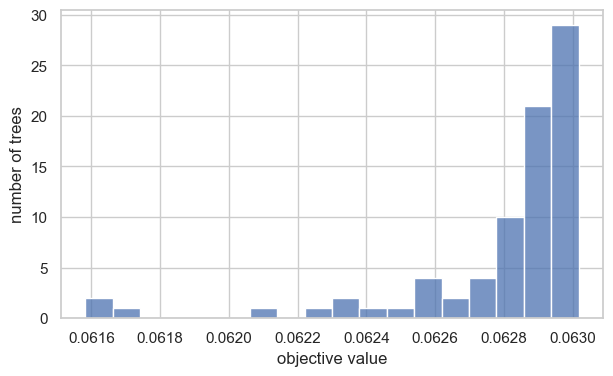

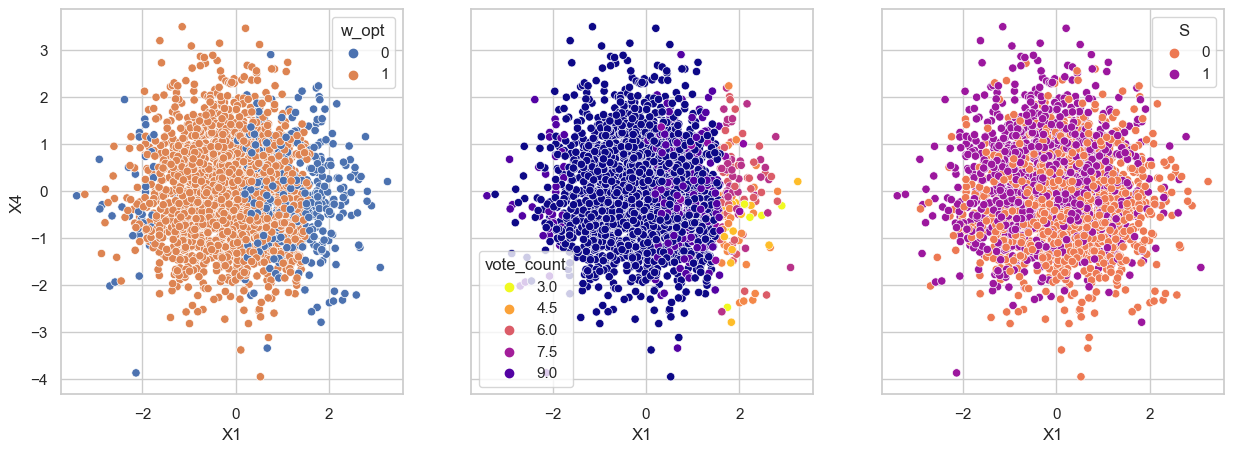

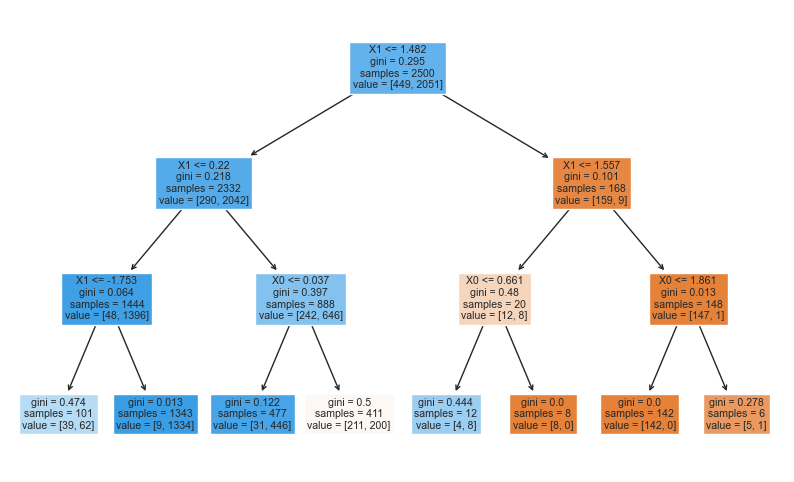

In [43]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
    leaf_proba=1,
    num_trees=1000,
    vote_threshold=9 / 10,
    top_k_trees=True,
    k=10,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))

fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
sns.histplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < baseline_loss
    ],
    ax=ax,
    fill=True,
)
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")


fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
sns.scatterplot(x="X1", y="X4", hue="w_opt", data=D_rash, ax=ax[0])
sns.scatterplot(
    x="X1", y="X4", hue="vote_count", data=D_rash, ax=ax[1], palette="plasma_r"
)
sns.scatterplot(x="X1", y="X4", hue="S", data=D_rash, ax=ax[2], palette="plasma_r")

sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S"]).columns,
    filled=True,
)
# fig.savefig("forest_opt_500trees_result_all_linear.pdf", format="pdf", dpi=600)

## Section 1.3. Strawman (Hard Mode) Example with under represented samples in the middle
$r = ( X_0^2  + X_1^2 )^{1/2}$ \
$P(S=1 | X) = 0.5 (r < 3) + 0.25 (3 \leq r \geq 5)  + 0.05$

$C = Bernoulli(0.75)$, \
$X_0 \sim C \mathcal{N}(0,1) + (1-C) \mathcal{N}(4,1)$, \
$X_1 \sim \mathcal{N}(X_0,3)$ \
$Y(0) = 0$, 
$Y(1) = X_0^2 + X_1^2$

<Axes: xlabel='X0', ylabel='X1'>

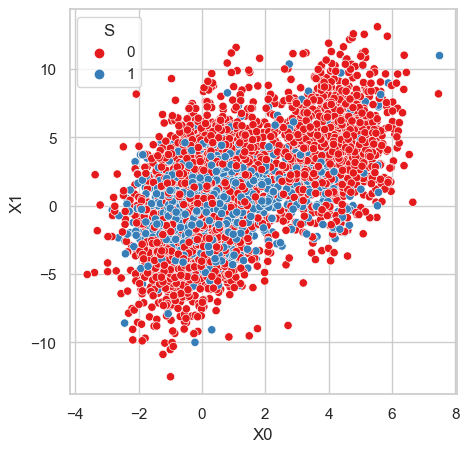

In [44]:
importlib.reload(strawman_center)
df, Y = strawman_center.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="X0", y="X1", hue="S", data=df, ax=ax, palette="Set1")

In [46]:
df_v, pi, pi_m, mu_1_m, mu_0_m, e_m, testing_data = learn.estimate_dml(
    data=df, outcome="Yobs", treatment="T", sample="S"
)

In [48]:
X = testing_data.drop(columns=["Yobs", "T", "S"])
S = testing_data["S"]
Spred = pi_m.predict_proba(X)[:, 1]

<Axes: xlabel='X0', ylabel='X1'>

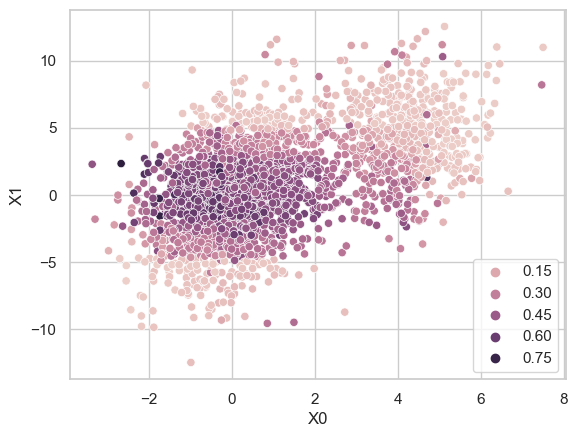

In [49]:
sns.scatterplot(x=X["X0"], y=X["X1"], hue=Spred)

<Axes: xlabel='X0', ylabel='X1'>

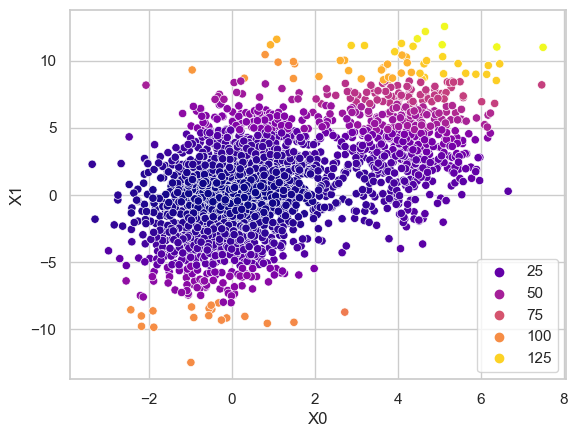

In [50]:
sns.scatterplot(x=X["X0"], y=X["X1"], hue=mu_1_m.predict(X), palette="plasma")

leaf    0.500000
X0      0.487234
X1      0.012766
dtype: float64
1.7181528473613896


[Text(0.5, 0.75, 'X0 <= 2.051\ngini = 0.381\nsamples = 2500\nvalue = [640, 1860]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 1860\nvalue = [0, 1860]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 640\nvalue = [640, 0]')]

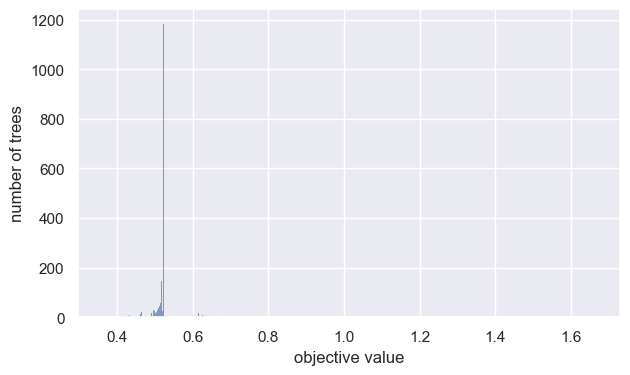

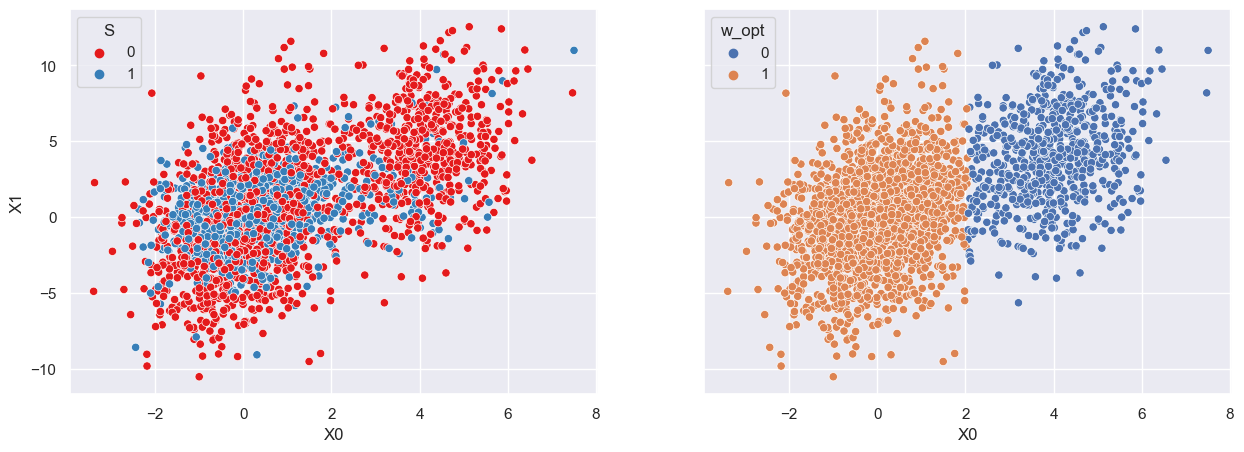

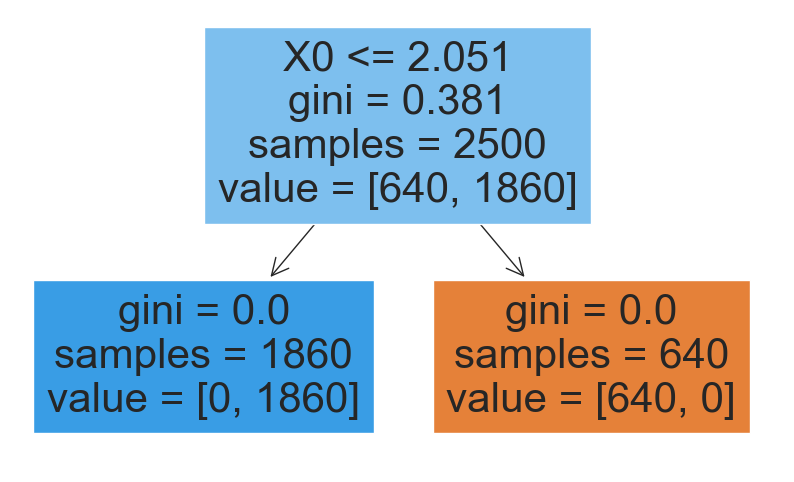

In [62]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=df,
    outcome="Yobs",
    treatment="T",
    sample="S",
    leaf_proba=1,
    num_trees=5000,
    vote_threshold=1 / 3,
    explore_proba=0.05,
    feature_est="Non-Linear",
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0]) ** 2))
print(baseline_loss)
fig, ax = plt.subplots(nrows=1, figsize=(7, 4))

sns.histplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < baseline_loss
    ],
    ax=ax,
    fill=True,
)
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")


fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
sns.scatterplot(x="X0", y="X1", hue="w_opt", data=D_rash, ax=ax[1])
sns.scatterplot(x="X0", y="X1", hue="S", data=D_rash, ax=ax[0], palette="Set1")

sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S"]).columns,
    filled=True,
)

(14.837287256452768, 0.8882358628564713, 17.517390010518245, 1.4231207793304197)


[Text(0.5, 0.875, 'X1 <= 8.333\ngini = 0.036\nsamples = 2500\nvalue = [46, 2454]'),
 Text(0.2, 0.625, 'X1 <= 7.8\ngini = 0.006\nsamples = 2442\nvalue = [7, 2435]'),
 Text(0.1, 0.375, 'gini = 0.0\nsamples = 2418\nvalue = [0, 2418]'),
 Text(0.3, 0.375, 'X0 <= 4.343\ngini = 0.413\nsamples = 24\nvalue = [7, 17]'),
 Text(0.2, 0.125, 'gini = 0.0\nsamples = 17\nvalue = [0, 17]'),
 Text(0.4, 0.125, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.8, 0.625, 'X1 <= 11.051\ngini = 0.441\nsamples = 58\nvalue = [39, 19]'),
 Text(0.7, 0.375, 'X0 <= 2.148\ngini = 0.325\nsamples = 49\nvalue = [39, 10]'),
 Text(0.6, 0.125, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(0.8, 0.125, 'gini = 0.133\nsamples = 42\nvalue = [39, 3]'),
 Text(0.9, 0.375, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]')]

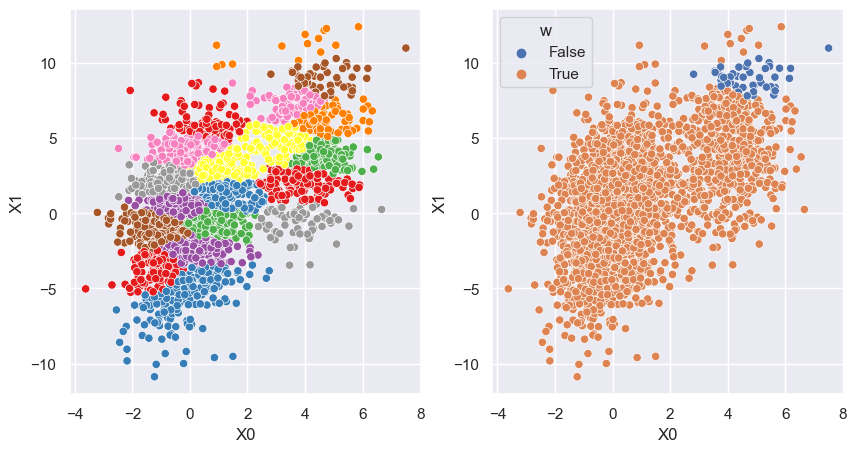

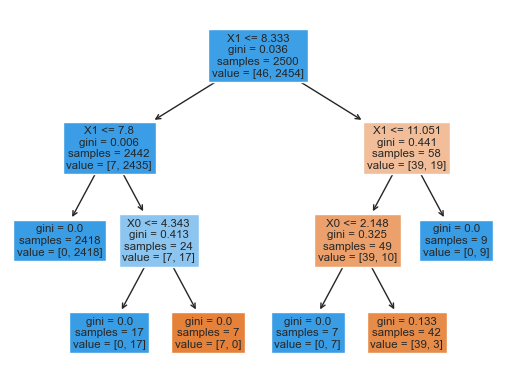

In [56]:
importlib.reload(learn)
np.random.seed(0)
D_labels, f, testing_data = learn.kmeans_opt(
    data=df, outcome="Yobs", treatment="T", sample="S", k=20
)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
sns.scatterplot(
    data=D_labels, x="X0", y="X1", hue="group", ax=ax[0], palette="Set1", legend=False
)
sns.scatterplot(data=D_labels, x="X0", y="X1", hue="w", ax=ax[1])


fig, ax = plt.subplots()
tree.plot_tree(
    f,
    feature_names=testing_data.drop(columns=["Yobs", "T", "S"]).columns,
    filled=True,
)

# plot_tree = tree.plot_tree(
#     f,
#     feature_names=testing_data.drop(columns=["Yobs", "T", "S", "w"]).columns,
#     ax=ax[1],
#     filled=True,
# )
# fig.savefig("voronoi_kmeans_opt_result.pdf", format="pdf", dpi=600)

# Section 2. LaLonde Analysis

In [69]:
nsw = pd.read_stata("http://www.nber.org/~rdehejia/data/nsw.dta")
psid_control = pd.read_stata("http://www.nber.org/~rdehejia/data/psid_controls.dta")

np.random.seed(0)
ATE_exp = (
    nsw.loc[nsw["treat"] == 1, "re78"].mean()
    - nsw.loc[nsw["treat"] == 0, "re78"].mean()
)
print("ATE Experimental: " + str(ATE_exp))
print("E[Y(1) | S=1]: " + str(nsw.loc[nsw["treat"] == 1, "re78"].mean()))
print("E[Y(0) | S=1]: " + str(nsw.loc[nsw["treat"] == 0, "re78"].mean()))
print(
    "E[ Y | T=0, S=0]: "
    + str(psid_control.loc[psid_control["treat"] == 0, "re78"].mean())
)

ATE Experimental: 886.3037
E[Y(1) | S=1]: 5976.352
E[Y(0) | S=1]: 5090.0483
E[ Y | T=0, S=0]: 21553.922


In [183]:
886 - 1.96 * (476), 886 + 1.96 * (476)

(-46.960000000000036, 1818.96)

In [75]:
df_lalonde = nsw.append(psid_control.drop(columns=["re74"]), ignore_index=True)
df_lalonde["data_id"] = (df_lalonde["data_id"] == "Lalonde Sample").astype(int)

In [76]:
df_v, pi, pi_m, mu_1_m, mu_0_m, e_m, testing_data = learn.estimate_dml(
    data=df_lalonde, outcome="re78", treatment="treat", sample="data_id"
)

In [171]:
importlib.reload(learn)

<module 'learn_w' from '/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/GitHub/fuse/learn_w.py'>

leaf         0.500000
age          0.000636
education    0.028055
black        0.176660
hispanic     0.201042
married      0.093248
nodegree     0.000357
re75         0.000002
dtype: float64
3632.478246594486


Text(0, 0.5, 'number of trees')

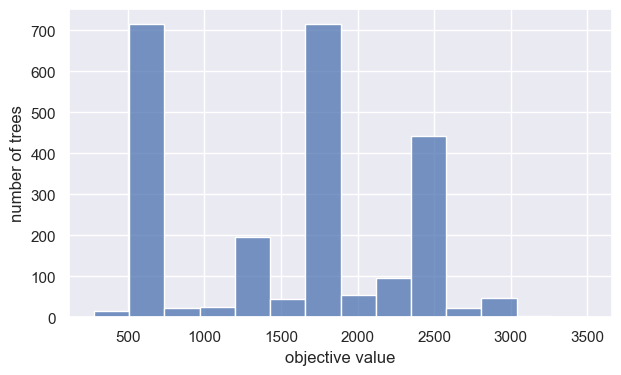

In [172]:
sns.set(font_scale=1)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=df_lalonde,
    outcome="re78",
    treatment="treat",
    sample="data_id",
    leaf_proba=1,
    num_trees=5000,
    vote_threshold=1 / 4,
    feature_est="Ridge",
    # top_k_trees=True,
    # k=100,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
print(baseline_loss)


fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
sns.histplot(
    [
        w_forest[i]["local objective"]
        for i in range(len(w_forest))
        if w_forest[i]["local objective"] < baseline_loss
    ],
    ax=ax,
    fill=True,
)
ax.set_xlabel("objective value")
ax.set_ylabel("number of trees")

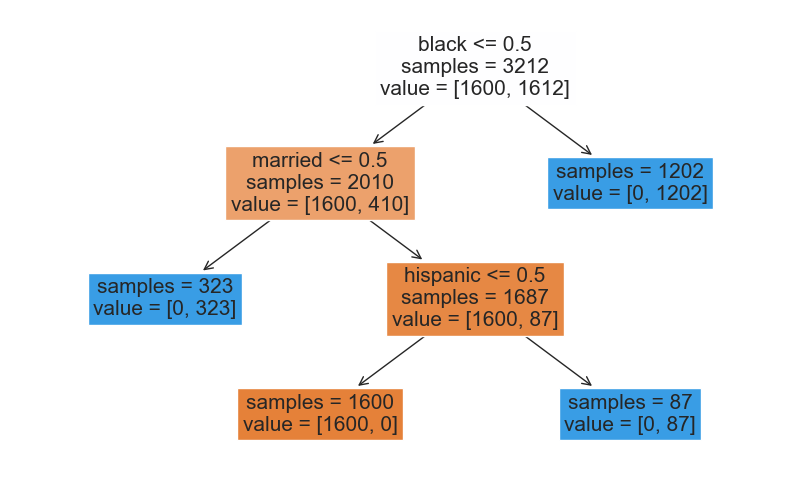

In [188]:
sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=testing_data.drop(columns=["re78", "treat", "data_id"]).columns,
    filled=True,
    impurity=False,
    fontsize=15,
)
fig.savefig("lalonde_forest.pdf", format="pdf", dpi=600)

In [174]:
df_lalonde_ = df_lalonde.loc[list(D_rash.index)].loc[D_rash["w_opt"] == 1]

In [175]:
df_v_, pi, pi_m, mu_1_m, mu_0_m, e_m, testing_data = learn.estimate_dml(
    data=df_lalonde_, outcome="re78", treatment="treat", sample="data_id", crossfit=50
)

df_v, pi, pi_m, mu_1_m, mu_0_m, e_m, testing_data = learn.estimate_dml(
    data=df_lalonde, outcome="re78", treatment="treat", sample="data_id", crossfit=50
)

(-50000.0, 50000.0)

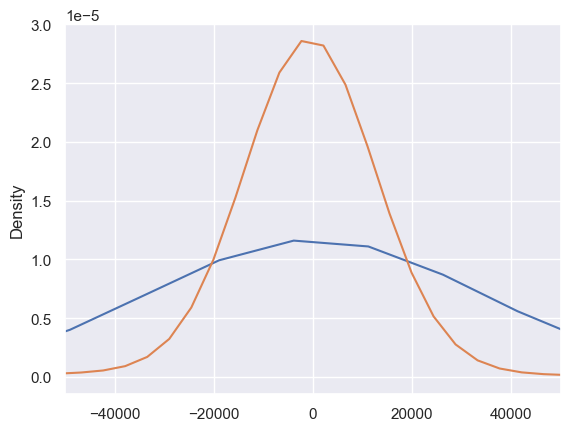

In [176]:
df_v["te"].plot(kind="kde")
df_v_["te"].plot(kind="kde")
plt.xlim(-50000, 50000)

In [178]:
df_v["te"].mean(), df_v_["te"].mean()

(4432.259406458402, 337.63339078069123)

In [181]:
df_v["te"].mean() - 1.96 * np.sqrt(
    df_v["te_sq"].sum() / (df_v["te_sq"].shape[0]) ** 2
), df_v["te"].mean() + 1.96 * np.sqrt(
    df_v["te_sq"].sum() / (df_v["te_sq"].shape[0]) ** 2
)

(-1346.083805008081, 10210.602617924884)

In [182]:
df_v_["te"].mean() - 1.96 * np.sqrt(
    df_v_["te_sq"].sum() / (df_v_["te_sq"].shape[0]) ** 2
), df_v_["te"].mean() + 1.96 * np.sqrt(
    df_v_["te_sq"].sum() / (df_v_["te_sq"].shape[0]) ** 2
)

(-2350.8696255773293, 3026.1364071387115)

In [166]:
selection_model = lm.LogisticRegressionCV().fit(
    testing_data.drop(columns=["re78", "treat", "data_id"]), testing_data["data_id"]
)

In [167]:
pd.DataFrame(
    selection_model.coef_,
    columns=testing_data.drop(columns=["re78", "treat", "data_id"]).columns,
)

age  education    black  hispanic   married  nodegree      re75
0 -0.106857  -0.073898  1.58206  0.863236 -2.055968  1.012632 -0.000169

In [170]:
D_rash.groupby(by=["black", "married"]).mean()[["vote_count", "S"]]

vote_count         S
black married                       
0.0   0.0      1444.775000  0.368750
      1.0      1352.370107  0.013049
1.0   0.0      1058.770701  0.792994
      1.0        42.134948  0.193772

In [26]:
df_lalonde.groupby(by=["black", "data_id"]).mean()["married"]

black  data_id
0.0    0          0.892283
       1          0.152778
1.0    0          0.788462
       1          0.164360
Name: married, dtype: float32